In [90]:
import awswrangler as wr
from transformers import pipeline
import pandas as pd
from sklearn.model_selection import train_test_split

In [81]:
pd.options.mode.copy_on_write = True

In [82]:
df = wr.s3.read_parquet(path="s3://amazon-reviews-eafit/sample/")

In [83]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_temp, test_size=0.5, random_state=42)

In [84]:
def zero_shot_classifier(
    df: pd.DataFrame,
    size_df=10,
    model="facebook/bart-large-mnli",
) -> None:
    data = df.head(size_df)
    classifier = pipeline(
        "zero-shot-classification",
        model=model,
    )

    results = classifier(
        list(data["review_body"]),
        candidate_labels=["positive", "neutral", "negative"],
    )
    prediction_sentiment = list(map(lambda x: x["labels"][0], results))

    data["prediction_sentiment"] = prediction_sentiment

    accuracy = (data["prediction_sentiment"] == data["sentiment"]).sum() / len(
        data["prediction_sentiment"]
    )

    print(f"The accuracy of the model is: {round(accuracy*100,2)}%")

In [85]:
def sentiment_analysis_classifier(
    df: pd.DataFrame,
    size_df=10,
    model="distilbert-base-uncased-finetuned-sst-2-english",
) -> None:
    data = df.head(size_df)
    data["review_body"] = data["review_body"].apply(lambda x: x[:450])
    classifier = pipeline("sentiment-analysis", model=model)

    results = classifier(list(data["review_body"]))
    prediction_sentiment = list(map(lambda x: x["label"].lower(), results))

    data["prediction_sentiment"] = prediction_sentiment

    accuracy = (data["prediction_sentiment"] == data["sentiment"]).sum() / len(
        data["prediction_sentiment"]
    )

    print(f"The accuracy of the model is: {round(accuracy*100,2)}%")

In [88]:
df_test["review_body_length"] = df_test["review_body"].apply(lambda x: len(x))

<Axes: title={'center': 'Review Body Length Distribution'}, ylabel='Frequency'>

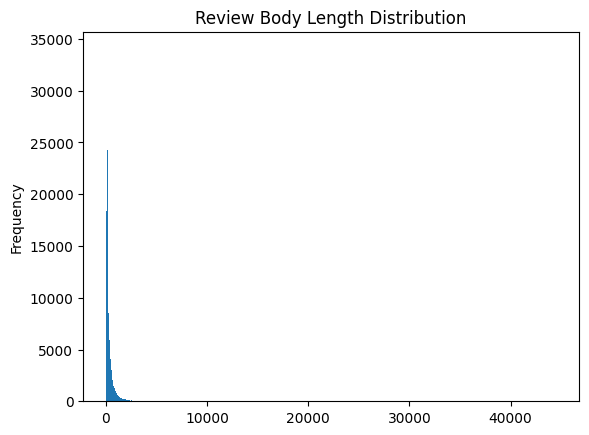

In [101]:
df_test["review_body_length"].plot(
    kind="hist", bins=1000, title="Review Body Length Distribution"
)

In [102]:
df_test["review_body_length"].describe()

count    199847.000000
mean        335.335792
std         624.104140
min           1.000000
25%          91.000000
50%         161.000000
75%         353.000000
max       44538.000000
Name: review_body_length, dtype: float64

In [113]:
sentiment_analysis_classifier(
    df_test,
    size_df=1000,
)

/Users/david/eafit/proyecto-integrador-semestre-2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The accuracy of the model is: 79.2%


In [114]:
zero_shot_classifier(df_test, size_df=1000)

/Users/david/eafit/proyecto-integrador-semestre-2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyboardInterrupt: 